## TD-Learning Cliff Walking Example

Similarly to the previous examples, we will start with defining our environment:

In [1]:
ENV["MPLBACKEND"]="qt4agg"
using PyPlot;pygui(true) 
using Random; Random.seed!(1234)
using ReinforcementLearning

In [2]:
#Auxiliary functions
function create_world(dx = 4,dy = 12)
    world = zeros(dx,dy)
    world[1,2:end-1] .= -1.0
    world[1,end] = 1.0
    return world
end

create_world (generic function with 3 methods)

In [3]:
#Now, define environment:

Base.@kwdef mutable struct CliffEnv <: AbstractEnv
    reward::Union{Nothing, Float64} = nothing
    actions::Dict{Int64, Tuple{Int64, Int64}}  = 
    Dict(1 => (0,-1), 2 => (1,0), 3 => (0,1), 4 => (-1,0))
    world::Matrix{Float64} = create_world()
    position::Int = 1
end
Main.CliffEnv

CliffEnv

In [4]:
#functions:
RLBase.action_space(env::CliffEnv) = Base.OneTo(length(env.actions))
RLBase.state_space(env::CliffEnv) = Base.OneTo(length(env.world))
RLBase.reward(env::CliffEnv) = env.reward
RLBase.state(env::CliffEnv) = env.position
RLBase.is_terminated(env::CliffEnv) = env.reward == -100.0 || env.reward == 0.0
function RLBase.reset!(env::CliffEnv) 
    env.reward = nothing
    env.position = 1
end

In [5]:
#and the most important function - movement control:
function (x::CliffEnv)(action)
    @assert action in action_space(x)
    direction = x.actions[action]
    cartesian_state = [CartesianIndices(x.world)[x.position][1],
                        CartesianIndices(x.world)[x.position][2]]
    new_state = cartesian_state .+ direction
    if !(new_state[1] ∈ 1:size(x.world,1) && new_state[2] ∈ 1:size(x.world,2))
        new_state = cartesian_state
    end   
    if x.world[new_state[1],new_state[2]] == -1.0
        x.reward = -100.0
    elseif x.world[new_state[1],new_state[2]] == 1.0
        x.reward = 0.0
    else
        x.reward = -1.0
    end
    x.position = LinearIndices(x.world)[new_state[1],new_state[2]]
    nothing
end

In [6]:
env = CliffEnv();
RLBase.test_runnable!(env)

Test Summary:               | Pass  Total  Time
random policy with CliffEnv | 2000   2000  0.0s


Test.DefaultTestSet("random policy with CliffEnv", Any[], 2000, false, false, true, 1.680675951282e9, 1.680675951321e9)

Now we will define the agent:

In [7]:
#tworzymy obiekt agent, ktory przechowuje wszystkie kluczowe informacje na temat agenta
mutable struct Agent
    algo::Symbol #algorytm uczenia
    env::CliffEnv #srodowisko
    ϵ::Float64 #współczynnik eksploracji
    β::Float64 #dyskonto
    α::Float64 #stopa uczenia się
    Q::Dict{Int64, Vector{Float64}} #slownik z nagrodami wynikajacymi z przejscia ze stanu do stanu
    score::Int #wynik - ile razy agent dotarl do mety
    cumulated_reward::Int #Skumulowana nagroda agenta w czasie
    rewards::Array{Float64,1} #wektor przecietnego wyniku agenta w trakcie symulacji
end

In [8]:
#konstruktor tworzacy agenta:
function Agent(algo; ϵ = 0.1,β = 0.99,α = 0.1) 
    if algo != :SARSA && algo != :Qlearning
        @error "unknown algorithm"
    end
    env = CliffEnv()
    Agent(algo, env,
        ϵ, β, α, 
        Dict{Tuple{Int64, Int64},Float64}(),
        0, 0, [])
end

Agent

And learning functions: one for SARSA algorithm and one for Q-Learning:

In [9]:
#funkcja uczenia sie agenta - algorytm Q Learning
#uzupelniamy wartosc macierzy Q dla zadanego stanu s i akcji a
#robimy to poprzez dodanie do nagrody za znalezienie sie w tym stanie zdyskontowanej najwyzszej nagrody jaka moze 
#uzyskac agent przenoszac sie z tego stanu do nowego:
#Q(s, a) = reward(s) + beta * max(Q(s'))
function learn!(agent, S, A, r, S′)
    if !haskey(agent.Q, S)
        agent.Q[S] = zeros(length(action_space(agent.env)))
        agent.Q[S][A] = r
    else
        Q_S′ = 0.0
        haskey(agent.Q, S′) && ( Q_S′ += maximum(agent.Q[S′]))
        agent.Q[S][A] += agent.α * (r + agent.β*Q_S′ - agent.Q[S][A])
    end
end

learn! (generic function with 1 method)

In [10]:
#funkcja uczenia sie agenta - algorytm SARSA
#uzupelniamy wartosc macierzy Q dla zadanego stanu s i akcji a
#robimy to poprzez dodanie do nagrody za znalezienie sie w tym stanie zdyskontowanej najwyzszej nagrody jaka moze 
#uzyskac agent przenoszac sie z tego stanu do nowego:
#Q(s, a) = reward(s) + beta * Q(s',a')
function learn!(agent, S, A, r, S′,A′)
    if !haskey(agent.Q, S)
        agent.Q[S] = zeros(length(action_space(agent.env)))
        agent.Q[S][A] = r
    else
        Q_S′ = 0.0
        haskey(agent.Q, S′) && (Q_S′ += agent.Q[S′][A′])
        agent.Q[S][A] += agent.α * (r + agent.β*Q_S′ - agent.Q[S][A])
    end
end

learn! (generic function with 2 methods)

Main function:

In [11]:
#funkcja kontrolujaca symulacje
function run_learning!(agent, episodes; plotting = true, burning = true)
    step = 1.0
    episode = 0.0
    #plot
    if plotting 
        field_val = agent.env.world[state(agent.env)]
        agent.env.world[state(agent.env)] = 2;
        img = imshow(agent.env.world);
        agent.env.world[state(agent.env)] = field_val
    end
    while episode ≤ episodes
        S = deepcopy(state(agent.env))
        if (burning && episode < 0.1 * episodes) || rand() < agent.ϵ || !haskey(agent.Q, state(agent.env))
            A = rand(1:length(action_space(agent.env)))
        else 
            A = argmax(agent.Q[state(agent.env)])
        end
        agent.env(action_space(agent.env)[A])
        r = reward(agent.env)
        S′ = deepcopy(state(agent.env))
        if agent.algo == :SARSA
            if (burning && episode < 0.1 * episodes) || rand() < agent.ϵ || !haskey(agent.Q, state(agent.env))
                A′ = rand(1:length(action_space(agent.env)))
            else 
                A′ = argmax(agent.Q[state(agent.env)])
            end
            learn!(agent, S, A, r, S′,A′)
        else
            learn!(agent, S, A, r, S′)
        end
        agent.cumulated_reward += r
        if plotting
            field_val = agent.env.world[state(agent.env)]
            agent.env.world[state(agent.env)] = 2;
            img[:set_data](agent.env.world)  
            title("Episode: $episode, Score: $(agent.score)")
            show()         
            sleep(0.001)
            agent.env.world[state(agent.env)] = field_val
        end
        if is_terminated(agent.env)
            episode += 1.0
            push!(agent.rewards, agent.cumulated_reward/episode)
            reward(agent.env) == 0.0 && (agent.score += 1.0)
            reset!(agent.env)
        end
        step += 1.0    
    end 
end

run_learning! (generic function with 1 method)

It is time to run our agents. At first, let us take a look at Q-Learning agent before learning:

In [12]:
#uruchamiamy:

agent_Q = Agent(:Qlearning);
run_learning!(agent_Q,20,plotting = true, burning = false)

and after learning:

In [13]:
agent_Q = Agent(:Qlearning);
run_learning!(agent_Q,5000,plotting = false)
Q_rewards = deepcopy(agent_Q.rewards);
run_learning!(agent_Q,30,plotting = true, burning = false)

SARSA agent before:

In [15]:
agent_SARSA = Agent(:SARSA);
run_learning!(agent_SARSA,20,plotting = true, burning = false)

and after learning:

In [16]:
agent_SARSA = Agent(:SARSA);
run_learning!(agent_SARSA,5000,plotting = false)
SARSA_rewards = deepcopy(agent_SARSA.rewards);
run_learning!(agent_SARSA,30,plotting = true, burning = false)

Average rewards for both methods:

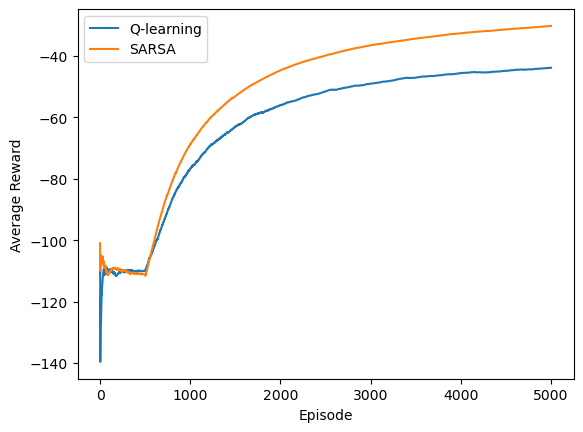

PyObject Text(24.0, 0.5, 'Average Reward')

In [17]:
pygui(false) 
plot(Q_rewards, label = "Q-learning")
plot(SARSA_rewards, label = "SARSA")
legend()
xlabel("Episode")
ylabel("Average Reward")